## <span style="color:olivedrab"> Exercise 04: Molecular Dynamics of a LJ model of Argon </span>

In [2]:
#import essential libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#parameter to use Latex in matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
#a plot label should be easy to read
plt.rcParams.update({'font.size': 14})

In this exercise we perform molecular dynamics simulations of Argon modellized via a Lennard-Jones potential: 
$$
V_\mathrm{LJ}(r)=4\epsilon \left[\left(\frac{\sigma}{r} \right)^{12} - \left(\frac{\sigma}{r} \right)^6 \right]
$$
it is natural to define $\textbf{reduced units}$:
- $r^\star=r/\sigma$
- $V^\star=V/\epsilon$
- $m^\star=m/ m_\mathrm{argon}$

in order to simplify the laws, avoid overflow and undeflow and most importantly, access the law of corresponding states, that allows one to map infinitely many systems on the same choice of parameters for the system.

The simulation is realized in the $\textbf{microcanonical ensemble}$ adopting an ergodic integration algorithm for the equation of motion: the Verlet integrator. Since the system lives in and explores the microcanonical ensemble, the total energy is conserved, and not the temperature.

Thanks to the law of corresponding states, we can simulate different phases of Argon with the same software, just varying the initial conditions of our simulations. Those are defined by three parameteres $N$, $T^\star$ and $\rho^\star$ that specify a point in the phase diagram of Argon:
 - $N$ is the number of particles, set to $108$ for each simulation.
 - by defining $\rho^\star$ the volume of the box is set since the number of particles is fixed. 
 - from $T^\star$ we extract some initial velocities for the particles of our system using the corresponding Boltzmann distribution. This way the system will start at $T^\star$.

However, since time evolution in our MD simulation is microcanonical and not canonical (i.e. at fixed temperature, which can be obtained by implementing a thermostat in the algorithm) the temperature will not be the same during the simulation. Given our interest to study the system at well defined $T^\star$ this poses a problem that will be addressed in the next section.    

In particular we want to study the following conditions:
1. solid phase: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
2. liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
3. gas phase: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)

that can be mapped to Argon with the considerations:
($\sigma = 0.34\, nm$, $\epsilon/k_B = 120K$ , $m=39.948$ amu)
so that
$$ T^\star=1 \,\Rightarrow\, T=120K \\ r^\star =1  \,\Rightarrow\, r=24\, \mathrm{atomi}/nm^3 $$

The cut-off radius is a maximum distance after which the two-particle LJ interaction is set to zero: it mainly is a concern to reduce computational complexity as evaluating the LJ potential is somewhat unnecessary when it approaches zero due to big relative distances. It is taken greater for low density phases, as the tails of the interaction have a greater contribution to the energy than in more dense system.

The results of our simulations, which will be shown in reduced units, are the progressive average values and uncertainties as a functions of the increasing number of blocks for the total internal energy per particle, $E^\star/N$, the potential energy per particle, $U^\star/N$, the kinetic energy per particle, $K^\star/N$, the temperature, $T^\star$, and the pressure, $P^\star$.

to calculate the $\textbf{pressure}\, P^t$ at time t we considered the generalized equipartition theorem and derived from it the expression
$$
P^t = \rho k_B T^t + \frac{1}{3V} \left\langle \sum_{i,j<i}^{N} 48\epsilon \left[ \left(\frac{\sigma}{|\vec{r}^t_i -\vec{r}^t_j|}\right)^{12} - 
\frac{1}{2} \left(\frac{\sigma}{|\vec{r}^t_i -\vec{r}^t_j|}\right)^6 \right] \right\rangle_\mathrm{trajectories}
$$
that we then implemented in the algorithm. Thus we are able to estimate the pressure of the system at every time step and also to estimate the progressive and blocking average and the relative uncertainty.

### <span style="color:purple"> Thermalization </span>

As the system is simulated in the microcanonical ensemble, the total energy is conserved while the temperature varies with time. However we can still use the simulation tool of choice to investigate equilibrium properties at a desired $T^\star$: in fact, after a transient the temperature of our system stabilizes and fluctuates around a defined value, as one can see from the simulation data plotted below, where $T^\star$ is depicted as a function of the timesteps taken (the number of steps per block is $1$).

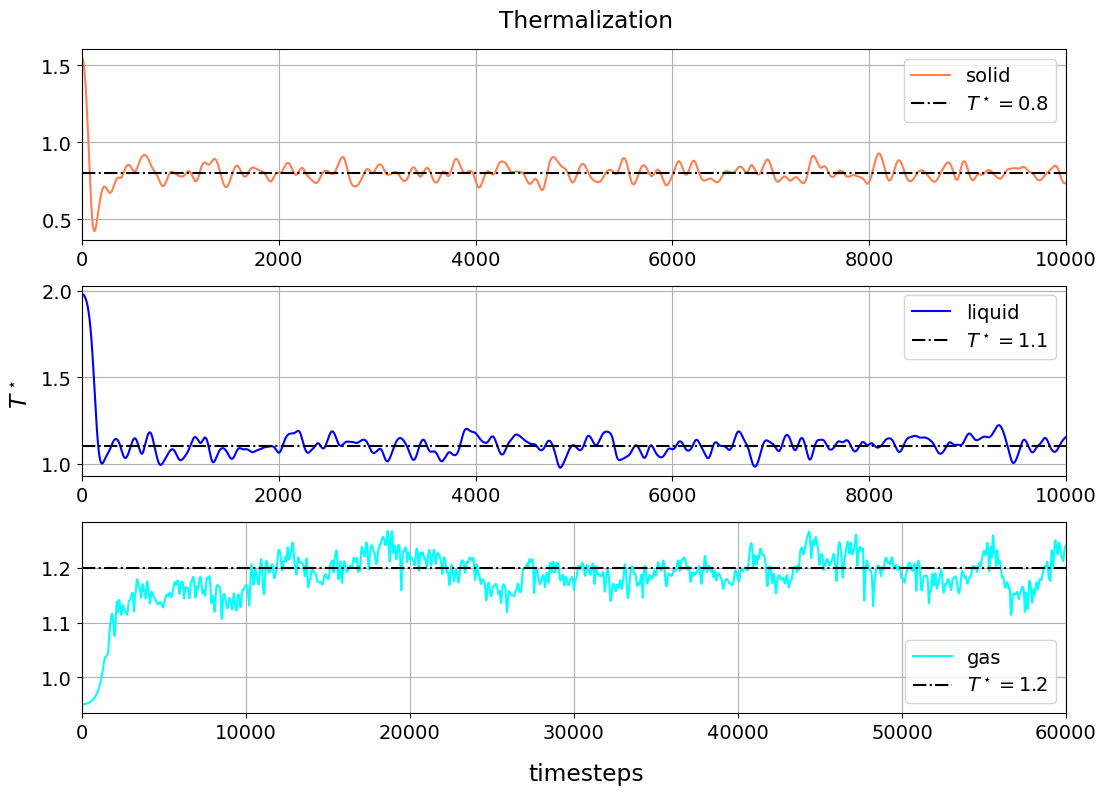

In [70]:
#temperature before thermalization

#import data formatted as table from a .txt file into a dictionary
thermalization_data = {
    'gas'    :  np.loadtxt('gas_simulation/thermalization/output_temp.dat'),
    'liquid' :  np.loadtxt('liquid_simulation/thermalization/output_temp.dat'),
    'solid'  :  np.loadtxt('solid_simulation/thermalization/output_temp.dat')
}

L=1                  # Block size

fig,ax = plt.subplots(3,1,figsize=(12,8))
axs = ax.flatten()
systems = ['solid','liquid','gas']
colors=['coral','blue','cyan']
T_target=[0.8,1.1,1.2]
#plot the temperatures
for i in range(3):
    axs[i].plot(thermalization_data[systems[i]][:,0]*L,thermalization_data[systems[i]][:,1], color=colors[i], label = systems[i])
    axs[i].grid(True)
    axs[i].axhline(y=T_target[i], color= "black",linestyle='-.', label=fr'$T^\star = {T_target[i]}$')
    axs[i].legend()
    axs[i].set_xbound(0,len(thermalization_data[systems[i]][:,0]))
fig.suptitle("Thermalization")
fig.supxlabel('timesteps')
fig.supylabel(r"$T^\star$")
plt.subplots_adjust(left=0.08, bottom=0.1, right=0.9, top=0.93, wspace=0.2, hspace=0.24)
plt.show()

The results plotted regard simulations starting from an fcc configuration and with starting $T^\star_0$ chosen to get the desired $T^\star \pm \sim 1\%$ after thermalization:
$$ \begin{cases}
T^\star_{0,\mathrm{solid}} = 1.55 &\rightarrow T^\star = 0.8 \\
T^\star_{0,\mathrm{liquid}} = 1.98 &\rightarrow T^\star = 1.1 \\ 
T^\star_{0,\mathrm{gas}} = 0.96 &\rightarrow T^\star = 1.2 
\end{cases} $$

The observed transient phenomena can be so explained:
 - in the solid and in the liquid, the fcc starting configuration is a deep minima in potential energy. Thus, as the entropy (i.e. particle motion) moves the system away from this minimum the potential energy increases. As the system is simulated in the microcanonical ensemble the total energy is constant, leading with the kinetic energy - and the temperature - decreasing steadily as the system reaches a more probable configuration in the phase space.
 
 - in the gaseous system however, the particles are so spread out (density is low) in the starting crystalline configuration that the potential is evaluated only on the potential's long tail, which is very weakly attractive. As the system explore new configurations, those with particle closer together become more frequent, lowering the potential energy of the system. As a consequence, the kinetic energy and the temperature increase.
 
As one can see, the gaseous system has longer thermalization time and a far longer fluctuation time scale. To investigate both of these properties the plot regarding gas thermalization is inspected for 6 times the timesteps.

In our simulation we modified the code to perform a number $\textit{thermalization_steps}$ of steps prior to every measurement to thermalize the system. $\textit{thermalization_steps}$ is passed to the algorithm as the last line in the file $\textit{input.in}$. Our choice of this parameter was based on the thermalization plots and made with the idea of surely skip the transient time:
$$ \mathrm{thermalization \ steps} \\
\begin{cases}
\mathrm{solid} &\rightarrow 4000 \\
\mathrm{liquid} &\rightarrow 4000 \\
\mathrm{gas} &\rightarrow 30000 \\
\end{cases} $$

### <span style="color:purple"> Correlations </span>

From the thermalization plots we can also estimate the fluctuation typical time scale. It is useful since we want to avoid our blocks to be of lower size, otherwise the correlation between data would disrupt the quality of the averages. To do so we have chosen
$$ \mathrm{number \ of \ steps\ per\ block} \\
\begin{cases}
\mathrm{solid} &\rightarrow 2000 \\
\mathrm{liquid} &\rightarrow 3000 \\
\mathrm{gas} &\rightarrow 15000 \\
\end{cases} $$

What happens when the block size is too small? We plot an evaluation of the temperature and its uncertainty for the gaseous system with $30$ blocks and $2000$ steps per block. It is clear from the thermalization plot that $2000$ steps are not enough to cancel out the fluctuations: e.g. the temperature can easily be much higher than the average temperature post-thermalization for more than 2000 time steps, and same is true regarding phase space explored in this fluctuation time, which may as well not correspond to "typical" phase space zone explored at equilibrium.

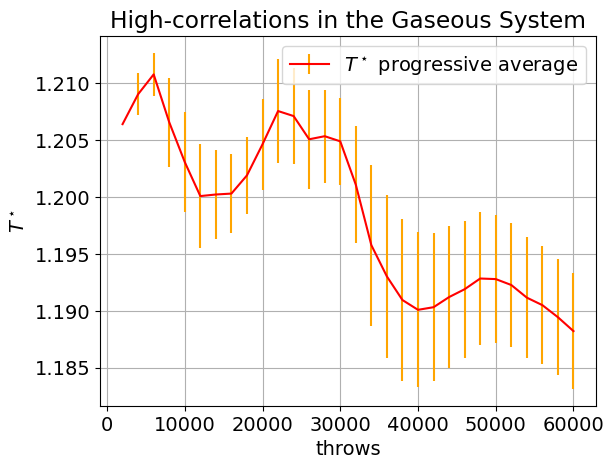

In [75]:
#Average analysis

#import data formatted as table from a .txt file
data = np.loadtxt('gas_simulation/high_correlation/output_temp.dat')

L=2000                  # Block size

#plot the results with errors
plt.errorbar(data[:,0]*L,data[:,2],yerr=
             data[:,3], color="red", ecolor="orange", label =r"$T^\star$ progressive average")
plt.xlabel('throws')
plt.ylabel(r"$T^\star$")
plt.grid(True)
plt.title("High-correlations in the Gaseous System")
plt.legend()
plt.show()

This correlation effect has the result of an atypical behaviour: the error bars increase as number of blocks increases. An example to justify this behaviour: as the block is small, the average calculated in the first block can be very different from the average calculated in the second, and so on. Since these averages are so different, the uncertainty will increase too.

This phenomenon suggests that our method of simulation is not correct: in particular it is not tailored to the system we are studying, as the number of steps in each block needs to be incremented.

### <span style="color:purple"> Results </span>
We performed solid and liquid simulations with $50$ blocks, while for gas we opted for $100$ blocks since the system proved to be tougher to study.

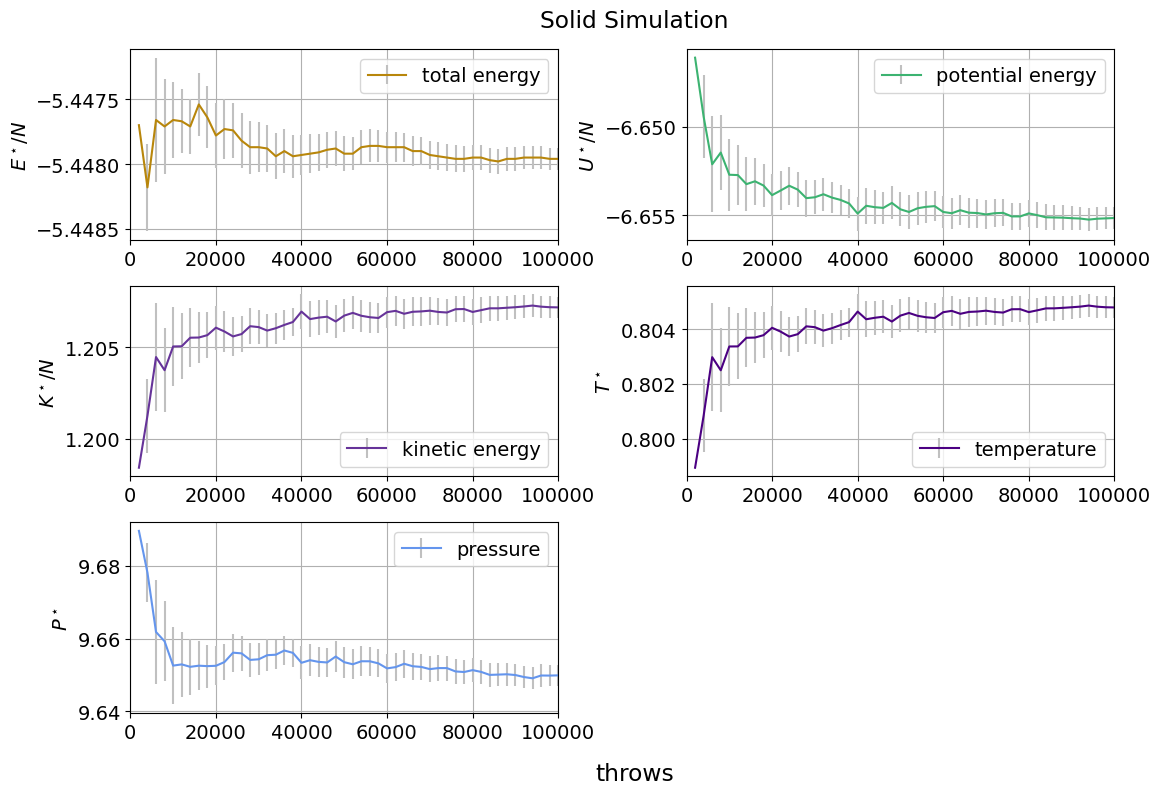

In [110]:
#Solid analysis

#import data formatted as table from a .txt file
data = {
    'total energy'       : np.loadtxt('solid_simulation/output_etot.dat'), 
    'potential energy'   : np.loadtxt('solid_simulation/output_epot.dat'), 
    'kinetic energy'     : np.loadtxt('solid_simulation/output_ekin.dat'), 
    'temperature'        : np.loadtxt('solid_simulation/output_temp.dat'), 
    'pressure'           : np.loadtxt('solid_simulation/output_pres.dat')
}

L=2000                  # Block size

quantities = ['total energy', 'potential energy', 'kinetic energy', 'temperature', 'pressure']

ylabels = [r'$E^\star/N$', r'$U^\star/N$', r'$K^\star/N$', r'$T^\star$', r'$P^\star$']

colors = ['darkgoldenrod','mediumseagreen','rebeccapurple', 'indigo','cornflowerblue']

fig,ax = plt.subplots(3,2,figsize=(12,8))
axs = ax.flatten()

#plot 
for i in range(5):
    axs[i].errorbar(data[quantities[i]][:,0]*L,data[quantities[i]][:,2],yerr=
             data[quantities[i]][:,3], color=colors[i], ecolor="silver", label = quantities[i])
    axs[i].grid(True)
    axs[i].legend()
    axs[i].set_xbound(0,len(data[quantities[i]][:,0])*L)
    axs[i].set_ylabel(ylabels[i])
axs[5].axis('off')
fig.suptitle("Solid Simulation")
fig.supxlabel('throws')
plt.subplots_adjust(left=0.08, bottom=0.1, right=0.9, top=0.93, wspace=0.3, hspace=0.24)
plt.show()

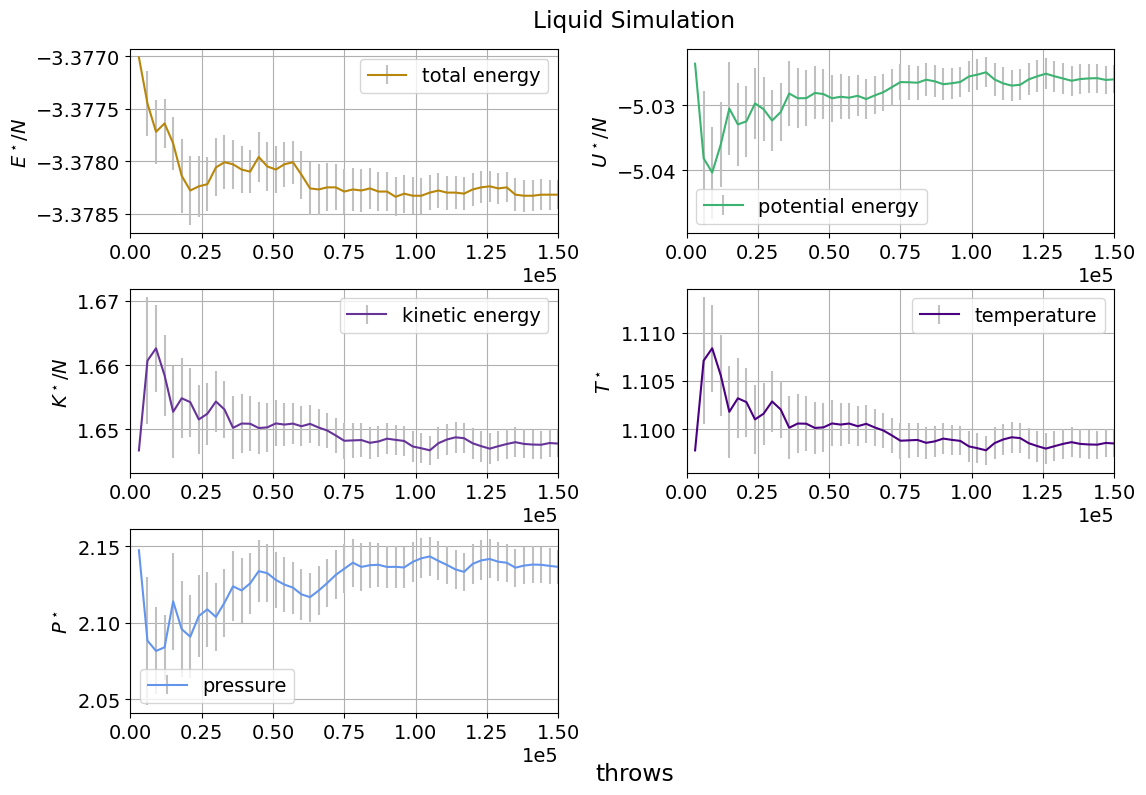

In [111]:
#Liquid analysis

#import data formatted as table from a .txt file
data = {
    'total energy'       : np.loadtxt('liquid_simulation/output_etot.dat'), 
    'potential energy'   : np.loadtxt('liquid_simulation/output_epot.dat'), 
    'kinetic energy'     : np.loadtxt('liquid_simulation/output_ekin.dat'), 
    'temperature'        : np.loadtxt('liquid_simulation/output_temp.dat'), 
    'pressure'           : np.loadtxt('liquid_simulation/output_pres.dat')
}

L=3000                  # Block size

quantities = ['total energy', 'potential energy', 'kinetic energy', 'temperature', 'pressure']

ylabels = [r'$E^\star/N$', r'$U^\star/N$', r'$K^\star/N$', r'$T^\star$', r'$P^\star$']

colors = ['darkgoldenrod','mediumseagreen','rebeccapurple', 'indigo','cornflowerblue']

fig,ax = plt.subplots(3,2,figsize=(12,8))
axs = ax.flatten()

#plot 
for i in range(5):
    axs[i].errorbar(data[quantities[i]][:,0]*L,data[quantities[i]][:,2],yerr=
             data[quantities[i]][:,3], color=colors[i], ecolor="silver", label = quantities[i])
    axs[i].grid(True)
    axs[i].legend()
    axs[i].set_xbound(0,len(data[quantities[i]][:,0])*L)
    axs[i].set_ylabel(ylabels[i])
    axs[i].ticklabel_format(axis='x',style='sci',scilimits=(0,1))
axs[5].axis('off')
fig.suptitle("Liquid Simulation")
fig.supxlabel('throws')
plt.subplots_adjust(left=0.08, bottom=0.1, right=0.9, top=0.93, wspace=0.3, hspace=0.30)
plt.show()

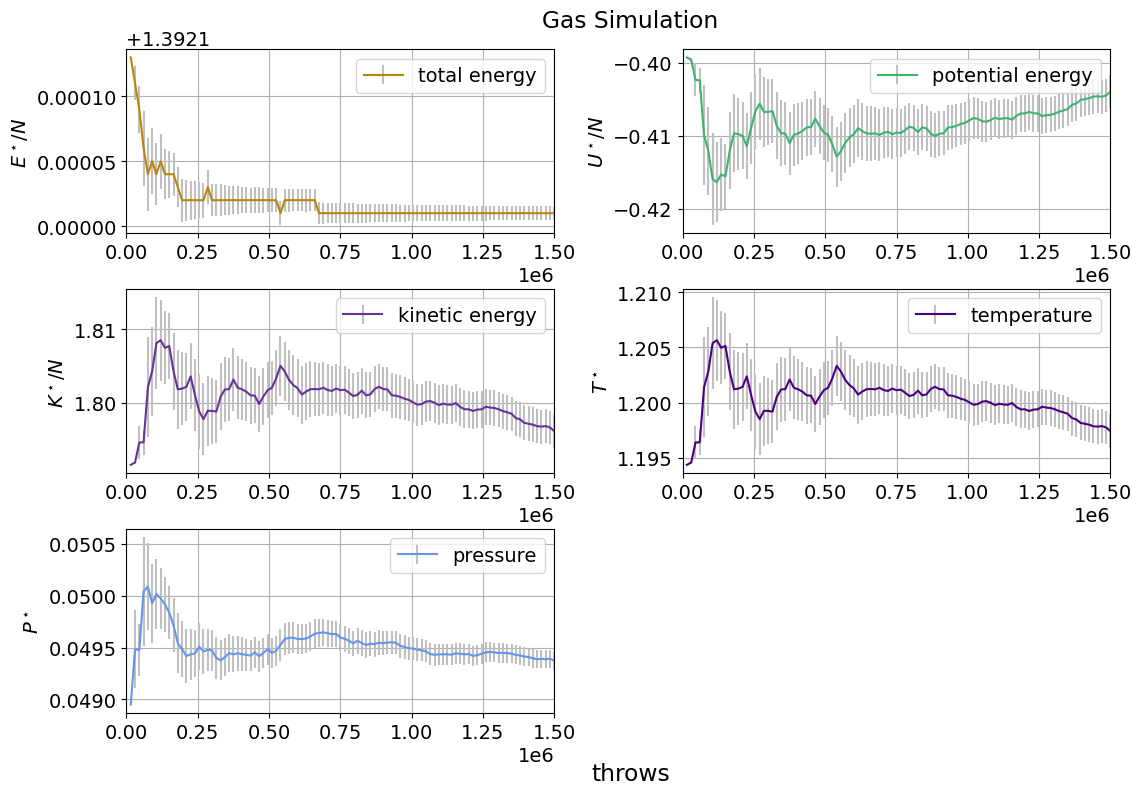

In [112]:
#Gas analysis

#import data formatted as table from a .txt file
data = {
    'total energy'       : np.loadtxt('gas_simulation/output_etot.dat'), 
    'potential energy'   : np.loadtxt('gas_simulation/output_epot.dat'), 
    'kinetic energy'     : np.loadtxt('gas_simulation/output_ekin.dat'), 
    'temperature'        : np.loadtxt('gas_simulation/output_temp.dat'), 
    'pressure'           : np.loadtxt('gas_simulation/output_pres.dat')
}

L=15000                  # Block size

quantities = ['total energy', 'potential energy', 'kinetic energy', 'temperature', 'pressure']

ylabels = [r'$E^\star/N$', r'$U^\star/N$', r'$K^\star/N$', r'$T^\star$', r'$P^\star$']

colors = ['darkgoldenrod','mediumseagreen','rebeccapurple', 'indigo','cornflowerblue']

fig,ax = plt.subplots(3,2,figsize=(12,8))
axs = ax.flatten()

#plot 
for i in range(5):
    axs[i].errorbar(data[quantities[i]][:,0]*L,data[quantities[i]][:,2],yerr=
             data[quantities[i]][:,3], color=colors[i], ecolor="silver", label = quantities[i])
    axs[i].grid(True)
    axs[i].legend()
    axs[i].set_xbound(0,len(data[quantities[i]][:,0])*L)
    axs[i].set_ylabel(ylabels[i])
    #axs[i].set_ylim(1.39210,1.39214)
axs[5].axis('off')
fig.suptitle("Gas Simulation")
fig.supxlabel('throws')
plt.subplots_adjust(left=0.08, bottom=0.1, right=0.9, top=0.93, wspace=0.3, hspace=0.30)
plt.show()

Please note: the total energy has long artificial plateaus since c++ standard output provides up to 5 decimal digits in scientific notation as a default. Considering the artifact is due to output setup, and not bug in calculations, and considering also that we are not interested in further precision, we are satisfied with the simulation without rerunning it.

General observations:
 - the solid phase, as expected, has the lowest potential, kinetic and total energy, while the gas phase has the highest.
 - the temperature is proportional to the kinetic energy per particle, so we can say that we have verified the equipartition theorem for this system.
 - looking at the plot shapes for the gas it seems to be true that $P \propto T$, as the equation of state for the van der Waals gas states.
 - total energy is conserved. And we can also observe from the plots (and from simulation data that is time dependent) that $K^\star + V^\star = E^\star$